# Setup

In [1]:
# NN and related metrics
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# General
import numpy as np
import os
import random
import pandas as pd

# Image and visualiztaion
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from PIL import Image

2023-05-17 17:13:39.963028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Specifying relevant paths
WORKING_DIRECTORY = os.getcwd()
DEPENDENCIES = os.path.join(WORKING_DIRECTORY, 'dependencies')
MODELS = os.path.join(DEPENDENCIES, 'models')
TEST = os.path.join(DEPENDENCIES, 'cnn_data', 'test')
YOLO = os.path.join(DEPENDENCIES, 'yolov5')
YOLO_MODEL = os.path.join(YOLO, 'exam', 'models')

## Importing CNN Models

In [4]:
Xception = keras.models.load_model(f'{MODELS}/Xception_model_v2.keras')
TinyVGG = keras.models.load_model(f'{MODELS}/TinyVGG_Model_v2.keras')

In [5]:
TinyVGG.get_compile_config()

{'optimizer': {'module': 'keras.optimizers.experimental',
  'class_name': 'SGD',
  'config': {'name': 'SGD',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': False,
   'is_legacy_optimizer': False,
   'learning_rate': 0.0010000000474974513,
   'momentum': 0.0,
   'nesterov': False},
  'registered_name': None},
 'loss': {'module': 'keras.losses',
  'class_name': 'SparseCategoricalCrossentropy',
  'config': {'reduction': 'auto',
   'name': 'sparse_categorical_crossentropy',
   'from_logits': False,
   'ignore_class': None,
   'fn': 'sparse_categorical_crossentropy'},
  'registered_name': None},
 'metrics': [[{'module': 'keras.metrics',
    'class_name': 'MeanMetricWrapper',
    'config': {'name': 'accuracy',
     'dtype': 'float32',
     'fn': {'module': 'builtins',
      'class_name': 'function',
      'config': 'sparse_categorical_accuracy',

## Importing Test Data

In [6]:
img_height, img_width = 250, 250

# Importing as tensorflow dataset for easy evaluation
tensorflow_test = tf.keras.utils.image_dataset_from_directory(
    TEST,
    labels='inferred',
    color_mode='rgb',
    seed=42,
    batch_size=32,
    image_size=(img_height, img_width),)

# class names
class_names = tensorflow_test.class_names
class_index = {index: name for index, name in enumerate(class_names)}
print(f'Class index of class names {class_index}')

Found 300 files belonging to 3 classes.
Class index of class names {0: 'bicycle', 1: 'car', 2: 'person'}


In [7]:
### To make image visualization easier, and for making predictions on test set, we will import them also as arrays

# We need to reshape images, so that our model will accept it (It expects batch-inputs)
new_shape = (1, 250, 250, 3)

# Extracting image path using OS
bicycle_array = [os.path.join(TEST, 'bicycle', img) for img in os.listdir(os.path.join(TEST, 'bicycle'))]
# Reshaping picture so that models will accept them (1,250,250, 3), assigning label and adding PIL.Image render to tuple, so x, y, img = bicycle[i] 
bicycle = [(np.reshape(cv2.imread(img), new_shape), 0, Image.open(img)) for img in bicycle_array]


##Same for the rest...
car_array = [os.path.join(TEST, 'car', img) for img in os.listdir(os.path.join(TEST, 'car'))]
car = [(np.reshape(cv2.imread(img), new_shape), 1, Image.open(img)) for img in car_array]

person_array = [os.path.join(TEST, 'person', img) for img in os.listdir(os.path.join(TEST, 'person'))]
person = [(np.reshape(cv2.imread(img), new_shape), 2, Image.open(img)) for img in person_array]

# Combining

imgs = bicycle_array + car_array + person_array
test_set = bicycle + car + person

random.shuffle(test_set)

# Tiny VGG

## Tiny VGG Summary

In [8]:
TinyVGG.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 125, 125, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 125, 125, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 63, 63, 64)        1792      
                                                                 
 activation_4 (Activation)   (None, 63, 63, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 activation_5 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)       

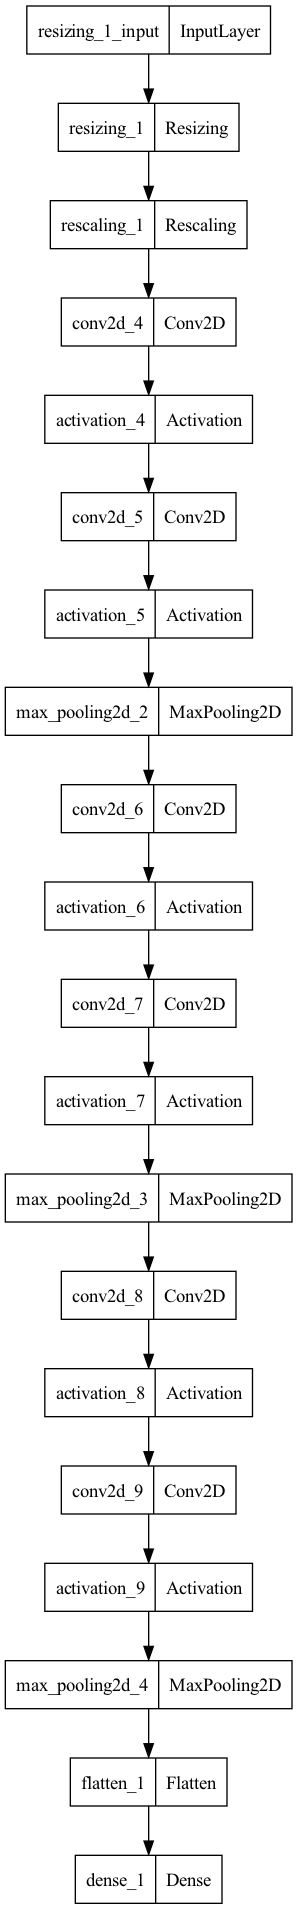

In [9]:
tf.keras.utils.plot_model(TinyVGG)

## Evaluate on test set

In [10]:
TinyVGG_results = TinyVGG.evaluate(tensorflow_test)

print(f'Spacial cross entropy loss: {round(TinyVGG_results[0], 2)}\nPercentage of correct predictions: {TinyVGG_results[1]:0.1%}')

2023-05-17 17:14:25.019766: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-05-17 17:14:25.020171: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [300]
	 [[{{node Placeholder/_0}}]]
2023-05-17 17:14:25.227067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 62ms/step - loss: 0.5882 - accuracy: 0.8000
Spacial cross entropy loss: 0.59
Percentage of correct predictions: 80.0%


### F1, Precision, Recall, Confusion Matrix

In [11]:
# Extracting labels and predictions for every image
vgg_y_true = []
vgg_y_pred = []

for img in test_set:
    x, y, i = img
    
    pred = TinyVGG(x)
    
    vgg_y_true.append(y)
    vgg_y_pred.append(np.argmax(pred, axis=1)[0])
    
# Transforming to arrays to pass through sklearn.metrics
vgg_y_true = np.array(vgg_y_true)
vgg_y_pred = np.array(vgg_y_pred)

In [12]:
# Calculate metrics
vgg_prf = precision_recall_fscore_support(vgg_y_true, vgg_y_pred)

# Transform into table
table =  [['precision'] + list(vgg_prf[0]),
['recall'] + list(vgg_prf[1]),
['fscore'] + list(vgg_prf[2])]

In [13]:
# Print in to tabulate form
print(tabulate(table, headers=[
      'Metric', class_index[0], class_index[1], class_index[2]]))


Metric       bicycle       car    person
---------  ---------  --------  --------
precision   0.757282  0.458599  0.675
recall      0.78      0.72      0.27
fscore      0.768473  0.560311  0.385714


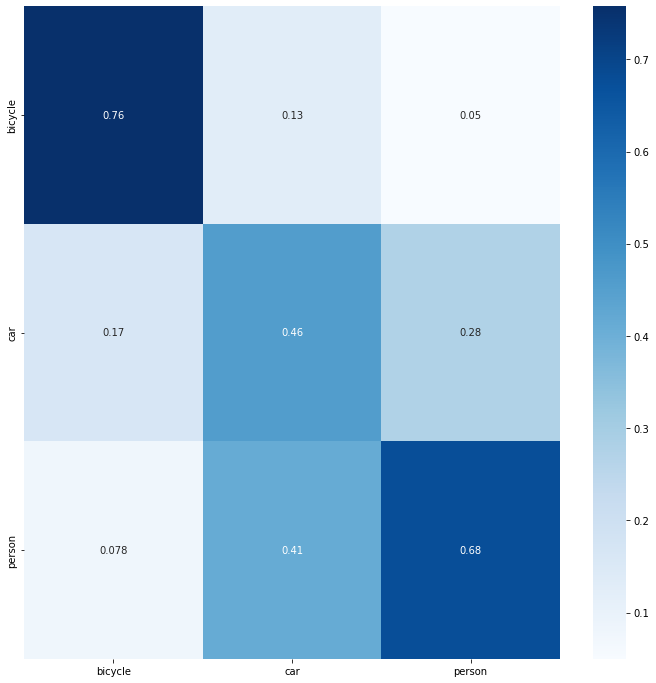

In [14]:
# Calculating confusion matrix
fig, ax = plt.subplots(figsize=(12,12))
vgg_cm = confusion_matrix(vgg_y_true, vgg_y_pred, normalize='pred')

sns.heatmap(vgg_cm, cmap='Blues', ax=ax, annot=True)

# Set the tick labels for x-axis
x_ticks = ax.get_xticks().tolist()

ax.set_xticklabels([class_index[int(x)] if int(x) in class_index else x for x in x_ticks])

# Set the tick labels for y-axis
y_ticks = ax.get_yticks().tolist()
ax.set_yticklabels([class_index[int(y)] if int(y) in class_index else y for y in y_ticks])


plt.show()

## Predictions

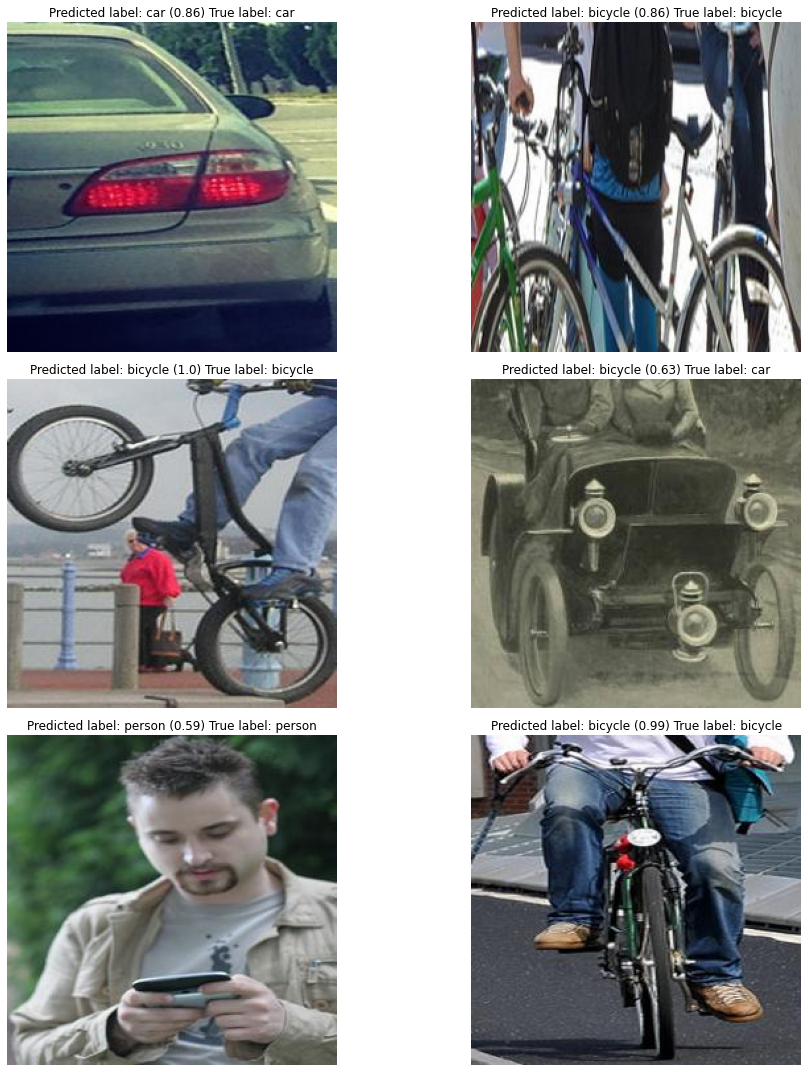

In [29]:
# Visualizing Predictions Across Images
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Looping through ax's
for ax in axs.flatten():

    # Get random image position
    index = random.randint(1, len(test_set)-1)

    # Extract images and labels from test set
    x, y_true, i = test_set[index]

    # Generate Prediction
    y_pred = TinyVGG(x)

    # Get class with highest probability
    y_pred_arg = np.argmax(y_pred, axis=1)[0]

    y_pred_prob = np.array(y_pred)[0][y_pred_arg]

    y_pred_prob = round(float(y_pred_prob), 2)

    ax.imshow(i)
    ax.set_title(
        f'Predicted label: {class_index[y_pred_arg]} ({y_pred_prob}) True label: {class_index[y_true]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


# Xception

## Xception Summary

In [15]:
Xception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 resizing_1 (Resizing)       (None, 125, 125, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling_1 (Rescaling)     (None, 125, 125, 3)          0         ['resizing_1[0][0]']          
                                                                                                  
 conv2d_4 (Conv2D)           (None, 63, 63, 128)          3584      ['rescaling_1[0][0]']         
                                                                                              

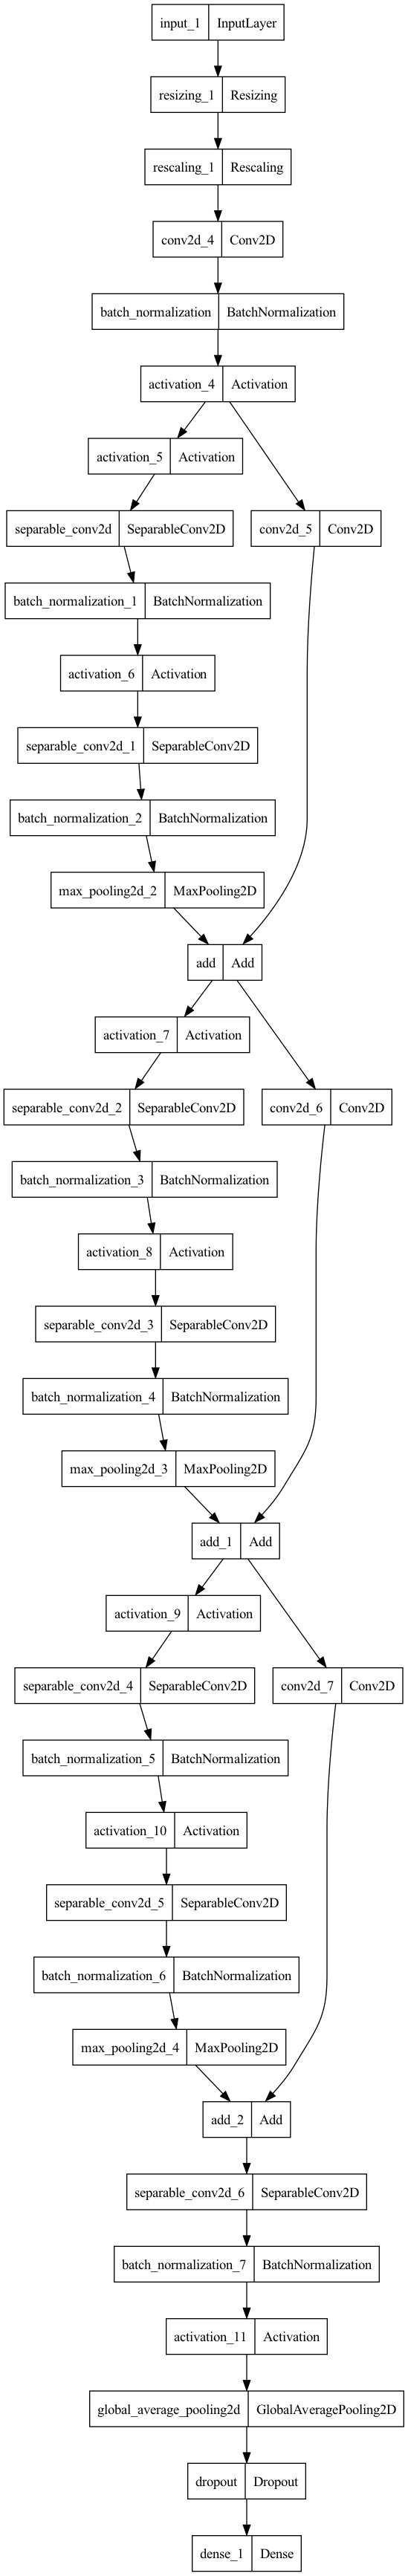

In [16]:
tf.keras.utils.plot_model(Xception)

## Evaluate on test set

In [18]:
Xception_results = Xception.evaluate(tensorflow_test)

print(
    f'Spatial cross entropy loss: {Xception_results[0]:0.2}\nPercentage of correct predictions: {Xception_results[1]:0.1%}')


10/10 [==============================] - 1s 101ms/step - loss: 0.5826 - accuracy: 0.8267
Spatial cross entropy loss: 0.58
Percentage of correct predictions: 82.7%


### F1, Precision, Recall, Confusion Matrix

In [19]:
# Extracting labels and predictions for every image
xc_y_true = []
xc_y_pred = []

for img in test_set:
    x, y, i = img
    
    pred = Xception(x)
    
    xc_y_true.append(y)
    xc_y_pred.append(np.argmax(pred, axis=1)[0])
    
# Transforming to arrays to pass through sklearn.metrics
xc_y_true = np.array(xc_y_true)
xc_y_pred = np.array(xc_y_pred)

In [20]:
Xception_prf = precision_recall_fscore_support(xc_y_true, xc_y_pred)

table =  [['precision'] + list(Xception_prf[0]),
['recall'] + list(Xception_prf[1]),
['fscore'] + list(Xception_prf[2])]

In [21]:
print(tabulate(table, headers=['Metric', class_index[0], class_index[1], class_index[2]]))

Metric       bicycle       car    person
---------  ---------  --------  --------
precision   0.796117  0.528986  0.711864
recall      0.82      0.73      0.42
fscore      0.807882  0.613445  0.528302


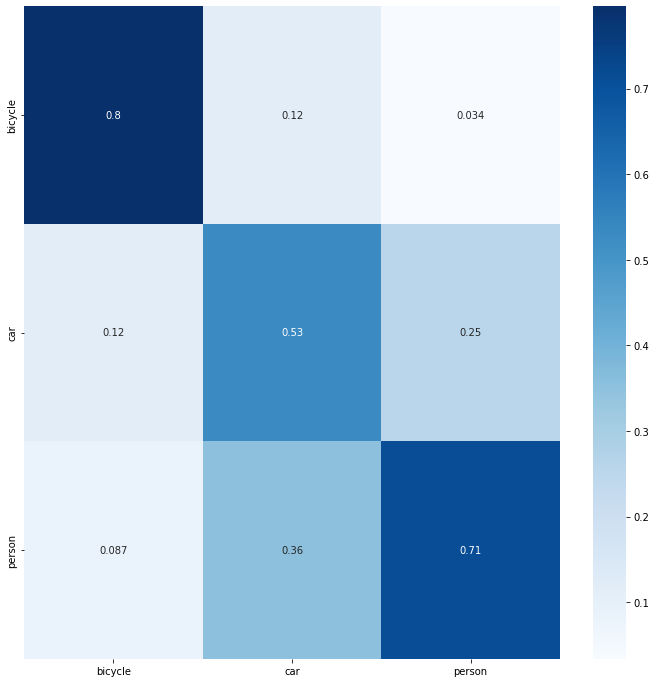

In [22]:
# Calculating confusion matrix
fig, ax = plt.subplots(figsize=(12,12))
cm = confusion_matrix(xc_y_true, xc_y_pred, normalize='pred')

sns.heatmap(cm, cmap='Blues', ax=ax, annot=True)

# Set the tick labels for x-axis
x_ticks = ax.get_xticks().tolist()

ax.set_xticklabels([class_index[int(x)] if int(x) in class_index else x for x in x_ticks])

# Set the tick labels for y-axis
y_ticks = ax.get_yticks().tolist()
ax.set_yticklabels([class_index[int(y)] if int(y) in class_index else y for y in y_ticks])


plt.show()

## Making Predictions 

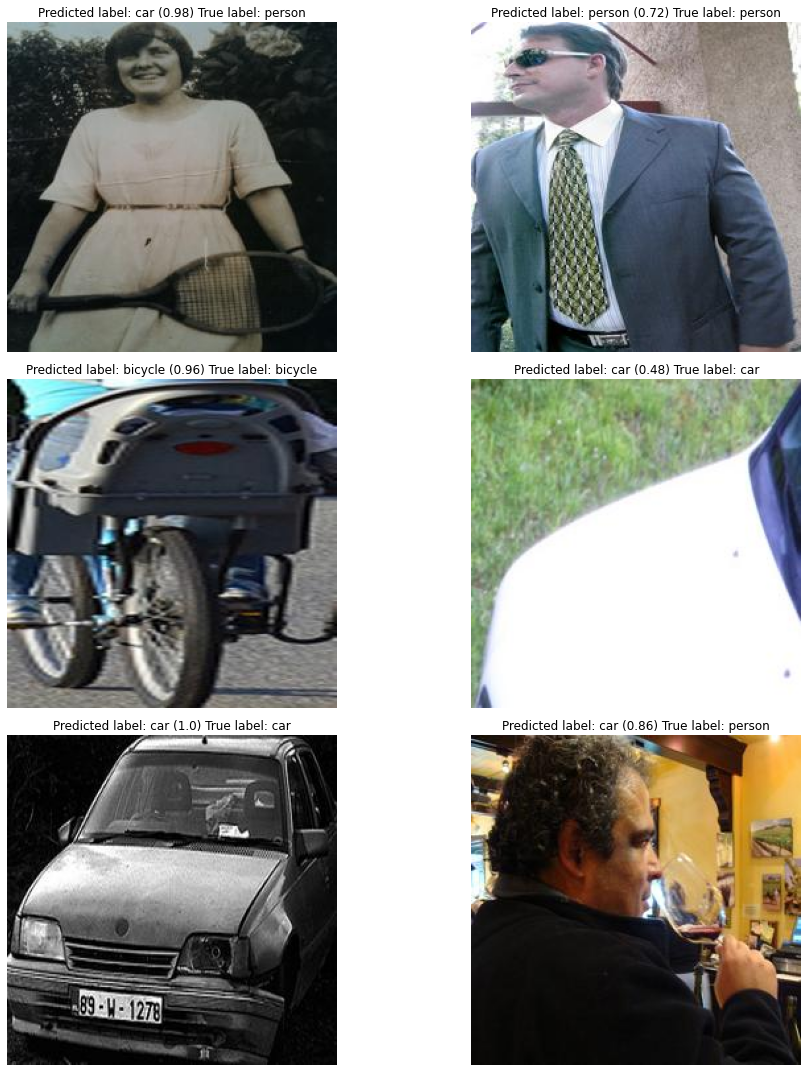

In [27]:
# Visualizing Predictions Across Images
fig, axs = plt.subplots(3,2, figsize=(15,15))

# Looping through ax's
for ax in axs.flatten():
    
    # Get random image position
    index = random.randint(1, len(test_set)-1)
    
    # Extract images and labels from test set
    x, y_true, i = test_set[index]
    
    # Generate Prediction
    y_pred = Xception(x)
    
    # Get class with highest probability
    y_pred_arg = np.argmax(y_pred, axis=1)[0]
    
    y_pred_prob = np.array(y_pred)[0][y_pred_arg]
    
    y_pred_prob = round(float(y_pred_prob), 2)
    
    ax.imshow(i)
    ax.set_title(f'Predicted label: {class_index[y_pred_arg]} ({y_pred_prob}) True label: {class_index[y_true]}')
    ax.axis('off')

plt.tight_layout()
plt.show()